Cargar el modelo ssd7 
(https://github.com/pierluigiferrari/ssd_keras#how-to-fine-tune-one-of-the-trained-models-on-your-own-dataset)

Training del SSD7 (modelo reducido de SSD). Parámetros en config_7.json y descargar VGG_ILSVRC_16_layers_fc_reduced.h5




In [ ]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import xml.etree.cElementTree as ET

import sys
sys.path += [os.path.abspath('../ssd_keras-master')]

from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast
from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from eval_utils.average_precision_evaluator import Evaluator
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize


def makedirs(path):
    try:
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise





K.tensorflow_backend._get_available_gpus()


def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

config_path = 'config_300_fault_1.json'


with open(config_path) as config_buffer:
    config = json.loads(config_buffer.read())

###############################
#   Parse the annotations
###############################
path_imgs_training = config['train']['train_image_folder']
path_anns_training = config['train']['train_annot_folder']
path_imgs_val =  config['test']['test_image_folder']
path_anns_val = config['test']['test_annot_folder']
labels = config['model']['labels']
categories = {}
#categories = {"Razor": 1, "Gun": 2, "Knife": 3, "Shuriken": 4} #la categoría 0 es la background
for i in range(len(labels)): categories[labels[i]] = i+1
print('\nTraining on: \t' + str(categories) + '\n')

####################################
#   Parameters
###################################
    #%%
img_height = config['model']['input'] # Height of the model input images
img_width = config['model']['input'] # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = len(labels) # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.01, 0.05, 0.1, 0.2, 0.37, 0.54, 0.71] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
#scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

K.clear_session() # Clear previous models from memory.


model_path = config['train']['saved_weights_name']
# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.


if config['model']['backend'] == 'ssd7':
    #weights_path = 'VGG_ILSVRC_16_layers_fc_reduced.h5'
    scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
    aspect_ratios = [0.5 ,1.0, 2.0] # The list of aspect ratios for the anchor boxes
    two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
    steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
    offsets = None

if os.path.exists(model_path):
    print("\nLoading pretrained weights.\n")
    # We need to create an SSDLoss object in order to pass that to the model loader.
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

    K.clear_session() # Clear previous models from memory.
    model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                           'L2Normalization': L2Normalization,
                                           'compute_loss': ssd_loss.compute_loss})


else:
    ####################################
    #   Build the Keras model.
    ###################################

    if config['model']['backend'] == 'ssd300':
        #weights_path = 'VGG_VOC0712Plus_SSD_300x300_ft_iter_160000.h5'
        from models.keras_ssd300 import ssd_300 as ssd

        model = ssd(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)


    elif config['model']['backend'] == 'ssd7':
        #weights_path = 'VGG_ILSVRC_16_layers_fc_reduced.h5'
        from models.keras_ssd7 import build_model as ssd
        scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
        aspect_ratios = [0.5 ,1.0, 2.0] # The list of aspect ratios for the anchor boxes
        two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
        steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
        offsets = None
        model = ssd(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_global=aspect_ratios,
                aspect_ratios_per_layer=None,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=None,
                divide_by_stddev=None)

    else :
        print('Wrong Backend')



    print('OK create model')
     #sgd = SGD(lr=config['train']['learning_rate'], momentum=0.9, decay=0.0, nesterov=False)

    # TODO: Set the path to the weights you want to load. only for ssd300 or ssd512

    weights_path = '../ssd_keras-master/VGG_ILSVRC_16_layers_fc_reduced.h5'
    print("\nLoading pretrained weights VGG.\n")
    model.load_weights(weights_path, by_name=True)

    # 3: Instantiate an optimizer and the SSD loss function and compile the model.
    #    If you want to follow the original Caffe implementation, use the preset SGD
    #    optimizer, otherwise I'd recommend the commented-out Adam optimizer.


    #adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)
    optimizer = Adam(lr=config['train']['learning_rate'], beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=optimizer, loss=ssd_loss.compute_loss)

    model.summary()


Using TensorFlow backend.



Training on: 	{'1': 1}


Loading pretrained weights.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instanciar los generadores de datos y entrenamiento del modelo.

*Cambio realizado para leer png y jpg. keras-ssd-master/data_generator/object_detection_2d_data_generator.py función parse_xml


In [16]:
#ENTRENAMIENTO DE MODELO
#####################################################################
#  Instantiate two `DataGenerator` objects: One for training, one for validation.
######################################################################
# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.



# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background' ] + labels

train_dataset.parse_xml(images_dirs= [config['train']['train_image_folder']],
                        image_set_filenames=[config['train']['train_image_set_filename']],
                        annotations_dirs=[config['train']['train_annot_folder']],
                        #classes=classes,
                        #include_classes='all',
                        classes = classes, 
                        include_classes= [1],
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs= [config['test']['test_image_folder']],
                        image_set_filenames=[config['test']['test_image_set_filename']],
                        annotations_dirs=[config['test']['test_annot_folder']],
                        #classes=classes,
                        #include_classes='all',
                        classes = classes, 
                        include_classes=[1],
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

#########################
# 3: Set the batch size.
#########################
batch_size = config['train']['batch_size'] # Change the batch size if you like, or if you run into GPU memory issues.

##########################
# 4: Set the image transformations for pre-processing and data augmentation options.
##########################
# For the training generator:


# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

######################################3
# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
#########################################
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
if config['model']['backend'] == 'ssd300':
    predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                       model.get_layer('fc7_mbox_conf').output_shape[1:3],
                       model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                       model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                       model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                       model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]
    ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                        img_width=img_width,
                                        n_classes=n_classes,
                                        predictor_sizes=predictor_sizes,
                                        scales=scales,
                                        aspect_ratios_per_layer=aspect_ratios,
                                        two_boxes_for_ar1=two_boxes_for_ar1,
                                        steps=steps,
                                        offsets=offsets,
                                        clip_boxes=clip_boxes,
                                        variances=variances,
                                        matching_type='multi',
                                        pos_iou_threshold=0.5,
                                        neg_iou_limit=0.5,
                                        normalize_coords=normalize_coords)

elif config['model']['backend'] == 'ssd7':
    predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                       model.get_layer('classes5').output_shape[1:3],
                       model.get_layer('classes6').output_shape[1:3],
                       model.get_layer('classes7').output_shape[1:3]]
    ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes,
                                predictor_sizes=predictor_sizes,
                                scales=scales,
                                aspect_ratios_global=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                steps=steps,
                                offsets=offsets,
                                clip_boxes=clip_boxes,
                                variances=variances,
                                matching_type='multi',
                                pos_iou_threshold=0.5,
                                neg_iou_limit=0.3,
                                normalize_coords=normalize_coords)



    
data_augmentation_chain = DataAugmentationVariableInputSize(resize_height = img_height,
                                                            resize_width = img_width,
                                                            random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))
#######################
# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
#######################

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=  [data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Summary instance training
category_train_list = []
for image_label in train_dataset.labels:
    category_train_list += [i[0] for i in image_label]
summary_category_training = {train_dataset.classes[i]: category_train_list.count(i) for i in list(set(category_train_list))}
for i in summary_category_training.keys():
     print(i, ': {:.0f}'.format(summary_category_training[i]))



# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))



##########################
# Define model callbacks.
#########################

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath= config['train']['saved_weights_name'],
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best =

csv_logger = CSVLogger(filename='log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]



batch_images, batch_labels = next(train_generator)


initial_epoch   = 0
final_epoch     = 100 #config['train']['nb_epochs']
steps_per_epoch = 500

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size*10),
                              initial_epoch=initial_epoch,
                              verbose = 1 if config['train']['debug'] else 2)

history_path = config['train']['saved_weights_name'].split('.')[0] + '_history'

np.save(history_path, history.history)

Processing image set 'test.txt': 100%|██████████| 117/117 [00:00<00:00, 449.85it/s]
1 : 2246
Number of images in the training dataset:	   783
Number of images in the validation dataset:	   117
Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
500/500 [==============================] - 471s 942ms/step - loss: 3.8465 - val_loss: 3.9360

Epoch 00001: val_loss improved from inf to 3.93599, saving model to experimento_ssd300_fault_1.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
500/500 [==============================] - 465s 931ms/step - loss: 3.8139 - val_loss: 3.8815

Epoch 00002: val_loss improved from 3.93599 to 3.88150, saving model to experimento_ssd300_fault_1.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
500/500 [==============================] - 460s 920ms/step - loss: 3.8367 - val_loss: 3.9229

Epoch 00003: val_loss did not improve from 3.88150
Epoch 4/100

Epoch 00004: Learning

500/500 [==============================] - 451s 902ms/step - loss: 3.5104 - val_loss: 3.3216

Epoch 00034: val_loss did not improve from 3.26357
Epoch 35/100

Epoch 00035: LearningRateScheduler setting learning rate to 0.001.
500/500 [==============================] - 450s 901ms/step - loss: 3.4535 - val_loss: 3.2405

Epoch 00035: val_loss improved from 3.26357 to 3.24054, saving model to experimento_ssd300_fault_1.h5
Epoch 36/100

Epoch 00036: LearningRateScheduler setting learning rate to 0.001.
500/500 [==============================] - 451s 902ms/step - loss: 3.4667 - val_loss: 3.2127

Epoch 00036: val_loss improved from 3.24054 to 3.21267, saving model to experimento_ssd300_fault_1.h5
Epoch 37/100

Epoch 00037: LearningRateScheduler setting learning rate to 0.001.
500/500 [==============================] - 450s 901ms/step - loss: 3.4625 - val_loss: 3.2967

Epoch 00037: val_loss did not improve from 3.21267
Epoch 38/100

Epoch 00038: LearningRateScheduler setting learning rate to 0

500/500 [==============================] - 449s 898ms/step - loss: 3.3732 - val_loss: 3.1180

Epoch 00069: val_loss did not improve from 3.07717
Epoch 70/100

Epoch 00070: LearningRateScheduler setting learning rate to 0.001.
500/500 [==============================] - 451s 901ms/step - loss: 3.3438 - val_loss: 3.1318

Epoch 00070: val_loss did not improve from 3.07717
Epoch 71/100

Epoch 00071: LearningRateScheduler setting learning rate to 0.001.
500/500 [==============================] - 451s 902ms/step - loss: 3.3451 - val_loss: 3.1492

Epoch 00071: val_loss did not improve from 3.07717
Epoch 72/100

Epoch 00072: LearningRateScheduler setting learning rate to 0.001.
500/500 [==============================] - 451s 901ms/step - loss: 3.3055 - val_loss: 3.1092

Epoch 00072: val_loss did not improve from 3.07717
Epoch 73/100

Epoch 00073: LearningRateScheduler setting learning rate to 0.001.
500/500 [==============================] - 450s 901ms/step - loss: 3.3299 - val_loss: 3.2583

Ep

In [ ]:
classes

dict_keys(['val_loss', 'loss', 'lr'])


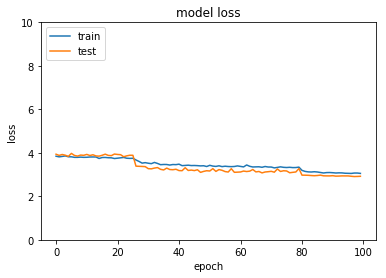

experimento_ssd300_fault_1.h5


In [17]:
#Graficar aprendizaje

history_path =config['train']['saved_weights_name'].split('.')[0] + '_history'

hist_load = np.load(history_path + '.npy',allow_pickle=True).item()

print(hist_load.keys())

# summarize history for loss
plt.plot(hist_load['loss'])
plt.plot(hist_load['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim((0, 10))  
plt.show()

print(config['train']['saved_weights_name'])

Evaluación del Modelo

In [1]:

config_path = 'config_300_fault_1.json'

with open(config_path) as config_buffer:
    config = json.loads(config_buffer.read())

    
model_mode = 'training'
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = config['train']['saved_weights_name']

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})


    
train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.



# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background' ] + labels

train_dataset.parse_xml(images_dirs= [config['train']['train_image_folder']],
                        image_set_filenames=[config['train']['train_image_set_filename']],
                        annotations_dirs=[config['train']['train_annot_folder']],
                        classes=classes,
                        include_classes='all',
                        #classes = ['background', 'panel', 'cell'], 
                        #include_classes=classes,
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs= [config['test']['test_image_folder']],
                        image_set_filenames=[config['test']['test_image_set_filename']],
                        annotations_dirs=[config['test']['test_annot_folder']],
                        classes=classes,
                        include_classes='all',
                        #classes = ['background', 'panel', 'cell'], 
                        #include_classes=classes,
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

#########################
# 3: Set the batch size.
#########################
batch_size = config['train']['batch_size'] # Change the batch size if you like, or if you run into GPU memory issues.







evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=val_dataset,
                      model_mode='training')

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=4,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results
total_instances = []
precisions = []

for i in range(1, len(average_precisions)):
    
    print('{:.0f} instances of class'.format(len(recalls[i])),
          classes[i], 'with average precision: {:.4f}'.format(average_precisions[i]))
    total_instances.append(len(recalls[i]))
    precisions.append(average_precisions[i])

if sum(total_instances) == 0:
    
    print('No test instances found.')

else:

    print('mAP using the weighted average of precisions among classes: {:.4f}'.format(sum([a * b for a, b in zip(total_instances, precisions)]) / sum(total_instances)))
    print('mAP: {:.4f}'.format(sum(precisions) / sum(x > 0 for x in total_instances)))

    for i in range(1, len(average_precisions)):
        print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
    print()
    print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

NameError: name 'json' is not defined

In [37]:
ceil(val_dataset_size/batch_size)

24

Cargar nuevamente el modelo desde los pesos.
Predicción

In [20]:
from imageio import imread
from keras.preprocessing import image
import time

config_path = 'config_300_fault_1.json'
input_path = ['fault_jpg_1/']
output_path = 'result_ssd300_fault_1/'

with open(config_path) as config_buffer:
    config = json.loads(config_buffer.read())

makedirs(output_path)
###############################
#   Parse the annotations
###############################
score_threshold = 0.25
score_threshold_iou = 0.5
labels = config['model']['labels']
categories = {}
#categories = {"Razor": 1, "Gun": 2, "Knife": 3, "Shuriken": 4} #la categoría 0 es la background
for i in range(len(labels)): categories[labels[i]] = i+1
print('\nTraining on: \t' + str(categories) + '\n')

img_height = config['model']['input'] # Height of the model input images
img_width = config['model']['input'] # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
n_classes = len(labels) # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
classes = ['background'] + labels

model_mode = 'training'
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = config['train']['saved_weights_name']

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})









Training on: 	{'1': 1}



In [21]:
image_paths = []
for inp in input_path:
    if os.path.isdir(inp):
        for inp_file in os.listdir(inp):
            image_paths += [inp + inp_file]
    else:
        image_paths += [inp]

image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg', '.png', 'JPEG'])]
times = []


for img_path in image_paths:
    orig_images = [] # Store the images here.
    input_images = [] # Store resized versions of the images here.
    #print(img_path)

    # preprocess image for network
    orig_images.append(imread(img_path))
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    input_images.append(img)
    input_images = np.array(input_images)
    # process image
    start = time.time()
    y_pred = model.predict(input_images)
    y_pred_decoded = decode_detections(y_pred,
                               confidence_thresh=score_threshold,
                               iou_threshold=score_threshold_iou,
                               top_k=200,
                               normalize_coords=True,
                               img_height=img_height,
                               img_width=img_width)


    #print("processing time: ", time.time() - start)
    times.append(time.time() - start)
    # correct for image scale

    # visualize detections
    # Set the colors for the bounding boxes
    colors = plt.cm.brg(np.linspace(0, 1, 21)).tolist()

    plt.figure(figsize=(20,12))
    plt.imshow(orig_images[0],cmap = 'gray')

    current_axis = plt.gca()
    #print(y_pred)
    for box in y_pred_decoded[0]:
        # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.

        xmin = box[2] * orig_images[0].shape[1] / img_width
        ymin = box[3] * orig_images[0].shape[0] / img_height
        xmax = box[4] * orig_images[0].shape[1] / img_width
        ymax = box[5] * orig_images[0].shape[0] / img_height

        color = colors[int(box[0])]
        label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

    #plt.figure(figsize=(15, 15))
    #plt.axis('off')
    save_path = output_path + img_path.split('/')[-1]
    plt.savefig(save_path)
    plt.close()
    
file = open(output_path + 'time.txt','w')

file.write('Tiempo promedio:' + str(np.mean(times)))

file.close()
print('Tiempo Total: {:.3f}'.format(np.sum(times)))
print('Tiempo promedio por imagen: {:.3f}'.format(np.mean(times)))
print('OK')

Tiempo Total: 27.768
Tiempo promedio por imagen: 1.111
OK


In [6]:

# Summary instance training
category_train_list = []
for image_label in train_dataset.labels:
    category_train_list += [i[0] for i in train_dataset.labels[0]]
summary_category_training = {train_dataset.classes[i]: category_train_list.count(i) for i in list(set(category_train_list))}
for i in summary_category_training.keys():
     print(i, ': {:.0f}'.format(summary_category_training[i]))


panel : 69
cell : 423


In [4]:
for i in summary_category_training.keys():
     print(i, ': {:.0f}'.format(summary_category_training[i]))

1 : 6030
